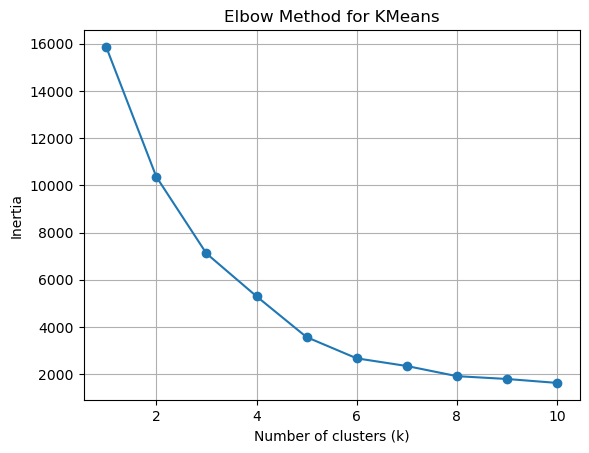

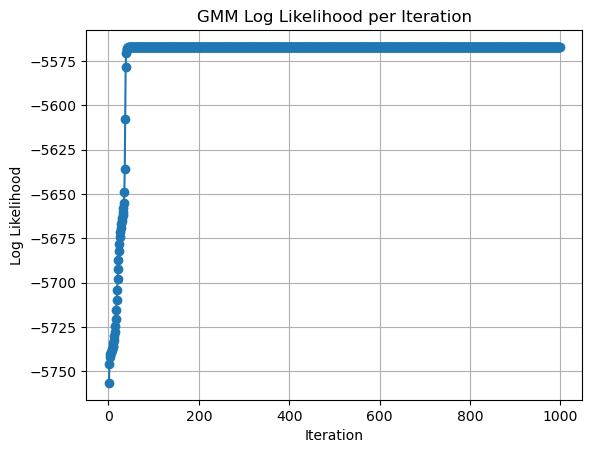

C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_35532\2259336816.py:195: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(mean, width, height, angle, edgecolor=colors[i%len(colors)], facecolor='none', lw=2, label=f'Component {i+1}' if v==1 else None)


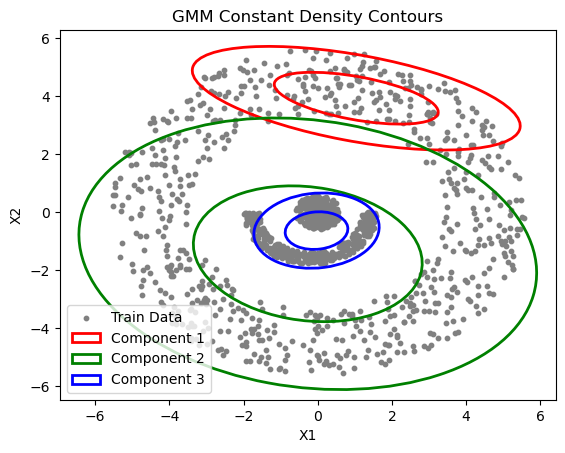

C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_35532\2259336816.py:216: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(means)))
C:\Users\Pratik Manusmare\AppData\Local\Temp\ipykernel_35532\2259336816.py:217: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  scatter = plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap=plt.cm.get_cmap('tab10', len(means)), edgecolor='k')


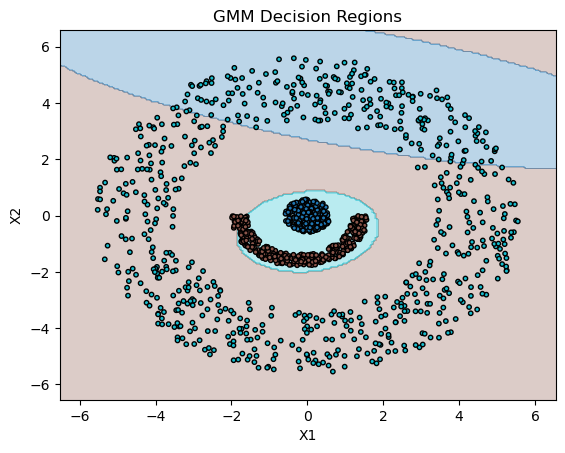

Confusion Matrix: [[0, 0, 90], [0, 5, 145], [89, 211, 0]]
Accuracy: 0.009259259259259259
Precision: [0.0, 0.023148148148148147, 0.0] Mean: 0.007716049382716049
Recall: [0.0, 0.03333333333333333, 0.0] Mean: 0.011111111111111112
F-measure: [0, 0.0273224043715847, 0] Mean: 0.009107468123861566


In [ ]:
import math
import random
import os
import numpy as np

# ===================== DATA LOADING FUNCTION ========================
def load_train_test_datasets(base_folder):
    def load_folder(folder):
        data = []
        labels = []
        class_map = {}  # Maps class name to label (e.g. 'class1' → 0)

        files = [f for f in os.listdir(folder) if f.endswith(".txt")]
        files.sort()  # Optional: for consistent ordering

        for file in files:
            path = os.path.join(folder, file)
            parts = file.split("_")
            class_name = parts[0]  # 'class1' from 'class1_train.txt'

            # Assign numeric label to class name
            if class_name not in class_map:
                class_map[class_name] = len(class_map)  # auto-labeling

            label = class_map[class_name]

            points = np.loadtxt(path, delimiter=' ')
            data.append(points)
            labels.append(np.full(len(points), label))

        return np.vstack(data), np.hstack(labels), class_map

    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")

    X_train, y_train, class_map = load_folder(train_folder)
    X_test, y_test, _ = load_folder(test_folder)  # test uses same class_map, but we ignore it

    return X_train, y_train, X_test, y_test, class_map
# ====================================================================

# ===================== KMEANS IMPLEMENTATION ========================
def euclidean_distance(a, b):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

def kmeans(X, k, max_iter=100):
    n = len(X)
    d = len(X[0])
    # Randomly initialize centroids
    centroids = random.sample(X, k)
    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]
        for x in X:
            idx = min(range(k), key=lambda i: euclidean_distance(x, centroids[i]))
            clusters[idx].append(x)
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append([sum(dim)/len(cluster) for dim in zip(*cluster)])
            else:
                new_centroids.append(random.choice(X))
        if all(euclidean_distance(c, nc) < 1e-4 for c, nc in zip(centroids, new_centroids)):
            break
        centroids = new_centroids
    return centroids, clusters

# ===================== GMM IMPLEMENTATION ===========================
def gaussian_pdf(x, mean, cov):
    d = len(x)
    det_cov = cov[0][0]*cov[1][1] - cov[0][1]*cov[1][0] if d == 2 else 1
    inv_cov = [[cov[1][1]/det_cov, -cov[0][1]/det_cov], [-cov[1][0]/det_cov, cov[0][0]/det_cov]] if d == 2 else [[1]]
    diff = [x[i] - mean[i] for i in range(d)]
    exp_term = -0.5 * sum(diff[i] * sum(inv_cov[i][j] * diff[j] for j in range(d)) for i in range(d))
    norm_const = 1.0 / (math.pow(2 * math.pi, d / 2) * math.sqrt(abs(det_cov)))
    return norm_const * math.exp(exp_term)

def gmm_fit(X, k, max_iter=100):
    n = len(X)
    d = len(X[0])
    # KMeans initialization
    means, clusters = kmeans(X, k)
    covs = []
    for cluster in clusters:
        if cluster:
            mean = [sum(dim)/len(cluster) for dim in zip(*cluster)]
            cov = [[0.0 for _ in range(d)] for _ in range(d)]
            for x in cluster:
                for i in range(d):
                    for j in range(d):
                        cov[i][j] += (x[i] - mean[i]) * (x[j] - mean[j])
            for i in range(d):
                for j in range(d):
                    cov[i][j] /= max(len(cluster), 1)
            covs.append(cov)
        else:
            covs.append([[1.0 if i==j else 0.0 for j in range(d)] for i in range(d)])
    weights = [len(cluster)/n for cluster in clusters]
    log_likelihoods = []
    for it in range(max_iter):
        # E-step
        resp = []
        for x in X:
            probs = [weights[j] * gaussian_pdf(x, means[j], covs[j]) for j in range(k)]
            total = sum(probs)
            resp.append([p/total if total > 0 else 1.0/k for p in probs])
        # M-step
        Nk = [sum(resp[i][j] for i in range(n)) for j in range(k)]
        for j in range(k):
            means[j] = [sum(resp[i][j] * X[i][dim] for i in range(n)) / Nk[j] for dim in range(d)]
            cov = [[0.0 for _ in range(d)] for _ in range(d)]
            for i in range(n):
                diff = [X[i][dim] - means[j][dim] for dim in range(d)]
                for a in range(d):
                    for b in range(d):
                        cov[a][b] += resp[i][j] * diff[a] * diff[b]
            for a in range(d):
                for b in range(d):
                    cov[a][b] /= Nk[j]
            covs[j] = cov
            weights[j] = Nk[j] / n
        # Log likelihood
        ll = sum(math.log(sum(weights[j] * gaussian_pdf(x, means[j], covs[j]) for j in range(k)) + 1e-10) for x in X)
        log_likelihoods.append(ll)
        print(f"Iteration {it+1}: Log Likelihood = {ll}")
    return means, covs, weights, log_likelihoods

# ===================== BAYES CLASSIFIER =============================
def gmm_predict(X, means, covs, weights):
    k = len(means)
    preds = []
    for x in X:
        probs = [weights[j] * gaussian_pdf(x, means[j], covs[j]) for j in range(k)]
        preds.append(probs.index(max(probs)))
    return preds

# ===================== METRICS =====================================
def confusion_matrix(y_true, y_pred, num_classes):
    matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for t, p in zip(y_true, y_pred):
        matrix[t][p] += 1
    return matrix

def precision_recall_fmeasure(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, num_classes)
    precisions, recalls, fmeasures = [], [], []
    for i in range(num_classes):
        tp = cm[i][i]
        fp = sum(cm[j][i] for j in range(num_classes) if j != i)
        fn = sum(cm[i][j] for j in range(num_classes) if j != i)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        fmeasure = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
        fmeasures.append(fmeasure)
    mean_precision = sum(precisions) / num_classes
    mean_recall = sum(recalls) / num_classes
    mean_fmeasure = sum(fmeasures) / num_classes
    return precisions, mean_precision, recalls, mean_recall, fmeasures, mean_fmeasure

def accuracy(y_true, y_pred):
    return sum(yt == yp for yt, yp in zip(y_true, y_pred)) / len(y_true)

# ===================== PLOTTING (BASIC) ============================
def plot_elbow(X, max_k=10):
    inertias = []
    for k in range(1, max_k+1):
        centroids, clusters = kmeans(X, k)
        inertia = sum(sum(euclidean_distance(x, centroids[i])**2 for x in cluster) for i, cluster in enumerate(clusters))
        inertias.append(inertia)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, max_k+1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for KMeans')
    plt.grid(True)
    plt.show()

def plot_contours(X, means, covs, weights):
    # Only works for 2D data
    import matplotlib.pyplot as plt
    import numpy as np
    X = np.array(X)
    plt.figure()
    plt.scatter(X[:,0], X[:,1], s=10, c='gray', label='Train Data')
    colors = ['r', 'g', 'b', 'm', 'c', 'y']
    for i, (mean, cov) in enumerate(zip(means, covs)):
        mean = np.array(mean)
        cov = np.array(cov)
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
        for v in [1, 2]:
            width, height = 2 * v * np.sqrt(eigvals)
            ell = plt.matplotlib.patches.Ellipse(mean, width, height, angle, edgecolor=colors[i%len(colors)], facecolor='none', lw=2, label=f'Component {i+1}' if v==1 else None)
            plt.gca().add_patch(ell)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('GMM Constant Density Contours')
    plt.legend()
    plt.show()

def plot_decision_regions(X, y, means, covs, weights):
    # Only works for 2D data
    import matplotlib.pyplot as plt
    import numpy as np
    X = np.array(X)
    y = np.array(y)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = gmm_predict(grid.tolist(), means, covs, weights)
    Z = np.array(Z).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(means)))
    scatter = plt.scatter(X[:,0], X[:,1], c=y, s=10, cmap=plt.cm.get_cmap('tab10', len(means)), edgecolor='k')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('GMM Decision Regions')
    plt.show()

def plot_log_likelihood(log_likelihoods):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(range(1, len(log_likelihoods)+1), log_likelihoods, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.title('GMM Log Likelihood per Iteration')
    plt.grid(True)
    plt.show()

# ===================== MAIN WORKFLOW ===============================

if __name__ == "__main__":
    # Load data from /dataset folder
    base_folder = r"../../Dataset/Group04/NLS_Group04/"

    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(base_folder)
    num_classes = len(class_map)

    # Elbow graph for KMeans
    plot_elbow(X_train.tolist(), max_k=10)

    # Fit GMM (example: k = num_classes)
    means, covs, weights, log_likelihoods = gmm_fit(X_train.tolist(), k=num_classes, max_iter=999)

    # Predict on test data
    y_pred = gmm_predict(X_test.tolist(), means, covs, weights)

    # Metrics
    acc = accuracy(y_test.tolist(), y_pred)
    precisions, mean_precision, recalls, mean_recall, fmeasures, mean_fmeasure = precision_recall_fmeasure(y_test.tolist(), y_pred, num_classes)
    cm = confusion_matrix(y_test.tolist(), y_pred, num_classes)

    # Log likelihood graph
    plot_log_likelihood(log_likelihoods)

    # Contour and decision region plots (placeholders)
    plot_contours(X_train.tolist(), means, covs, weights)
    plot_decision_regions(X_train.tolist(), y_train.tolist(), means, covs, weights)

    # Print results
    print('Confusion Matrix:', cm)
    print('Accuracy:', acc)
    print('Precision:', precisions, 'Mean:', mean_precision)
    print('Recall:', recalls, 'Mean:', mean_recall)
    print('F-measure:', fmeasures, 'Mean:', mean_fmeasure)